# LSA (Latent Semantic Analysis)

LSA attempts to reduce the high dimensional data created from tf-idf into a lower dimensional space using SVD. SVD stands for **Singular Value Decomposition**. It is used commonly in conjunction with tf-idf matrices to perform what is known as **Latent Semantic Analysis (LSA)**. Contrary to PCA, SVD will not center the data before reducing dimensions, which causes it to work better with sparse matrices (exactly what we have).

Otherwise, this is exactly the same as LDA Topic modelling.

This dimensionality reduction can be performed using truncated SVD. SVD, or singular value decomposition, is a technique in linear algebra that factorizes any matrix M as the product of 3 separate matrices: 

<!-- $$M=U*S*V$$ -->
![lsa.png](../images/lsa_1.png)

Where S is a diagonal matrix of the singular values of M. Critically, truncated SVD reduces dimensionality by selecting only the t largest singular values, and only keeping the first t columns of U and V. In this case, t is a hyperparameter we can select and adjust to reflect the number of topics we want to find.

![image.png](../images/lsa.png)

## Lets get to the code!

First we need to load in the functions and data:

In [1]:
import os
import json
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

df = pd.read_csv("../data/preprocessed.csv")

For LSA, we'll use the tf-idf matrix as a base to build upon. We will aim to try to reduce the 600 dimensions down to just 10 (arbitrarily chosen).

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

n_components = 8
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4),
                                           stop_words = 'english', max_features = 600)),
                 ('tfidf', TfidfTransformer())]).fit(df["coDescription_stopwords"])
#                  ('svd', TruncatedSVD(n_components = n_components))]).fit(df["coDescription"])
tf_idf = pd.DataFrame(pipe.transform(df["coDescription_stopwords"]).toarray())

## Plotting the results

Here are the results of running our data through LSA. If you're interested, the code is below:

```python
def visualize_svd(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    svd = TruncatedSVD(n_components = min(10,vectors.shape[1]))
    svd_embedding = svd.fit_transform(vectors)
    svd_embedding = pd.DataFrame(svd_embedding, index = multi_index)
    
    fig = px.scatter(svd_embedding, x =0 , y = 1, hover_data={"name": svd_embedding.index.get_level_values(0),
                                                              "industry": svd_embedding.index.get_level_values(1)},
                     color = svd_embedding.index.get_level_values(1), width=1100, height=700)
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y = -.25,
        xanchor="center",
        x = .5
    ))
    fig.show()
    
    return [svd, svd_embedding]
```

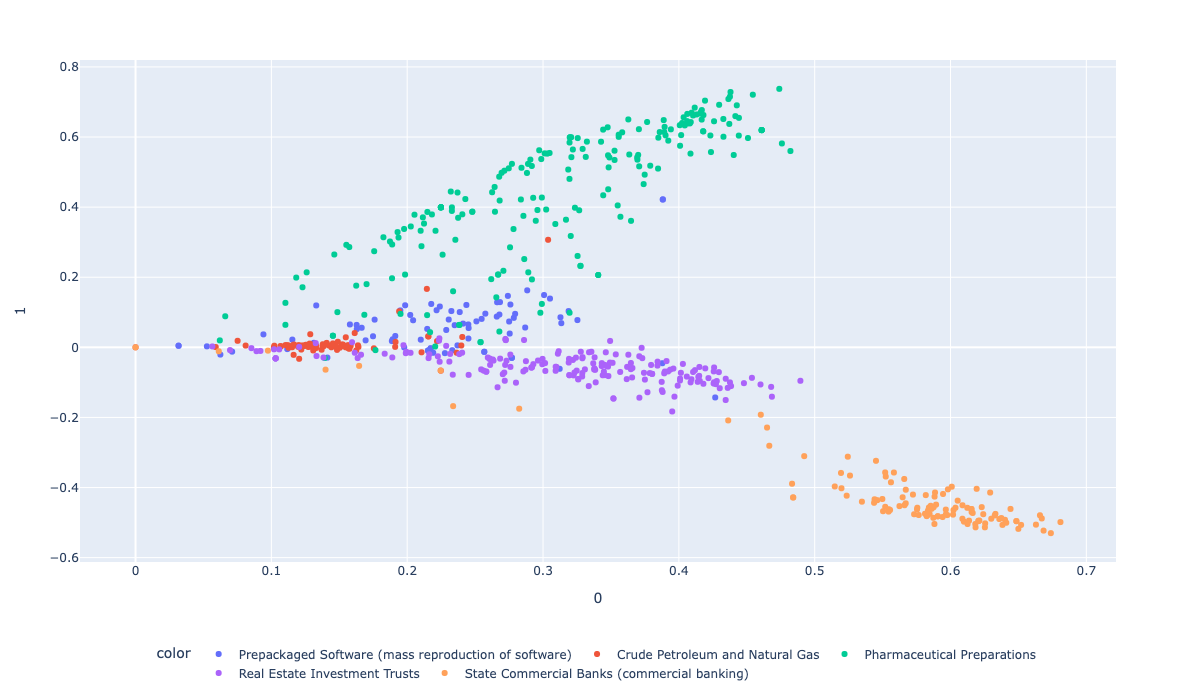

In [3]:
plot_svd = std_func.visualize_svd(tf_idf, df.loc[:,["name","SIC_desc"]])

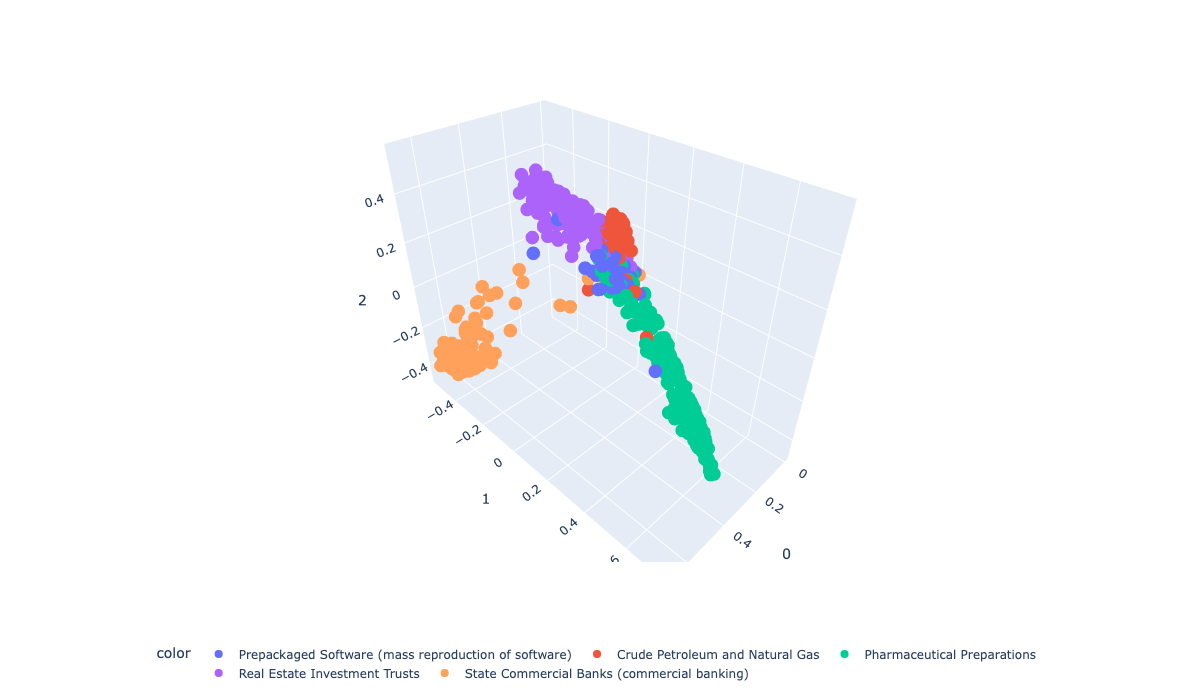

In [4]:
std_func.pca_visualize_3d(plot_svd)

Looking at the explained variance ratio, the dimensions don't capture much of the variation that exists within our data/companies (around 40%).

In [5]:
plot_svd[0].explained_variance_ratio_

array([0.02588462, 0.11616382, 0.08248699, 0.06525807, 0.03376197,
       0.01886247, 0.01790621, 0.01717385, 0.01690058, 0.01584811])

In [8]:
plot_svd[0].explained_variance_ratio_.sum()

0.41024667582533175